In [1]:
import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import count
from pyspark.sql.functions import max, min, col

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import altair as alt

import numpy as np
import pandas as pd

from graphframes import *
from pyspark.sql.types import *
from graphframes import *

import networkx as nx

In [2]:
# Load external packages programatically 
# Here, we assume that you use Spark 3.0.1 or later (compiled against Scala 2.12)
import os
packages = "graphframes:graphframes:0.8.1-spark3.0-s_2.12"
# jars = "graphframes-0.3.0-spark2.0-s_2.11.jar"

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--repositories https://repos.spark-packages.org/ --packages {0} pyspark-shell".format(packages)
)
#os.environ["PYSPARK_SUBMIT_ARGS"] = (
#    "--packages {0} --jars {1} pyspark-shell".format(packages, jars)
#)

In [3]:
spark = (SparkSession     
         .builder     
         .appName("Netflix")     
         .getOrCreate())

In [4]:
df = pd.read_csv('../data/netflix_titles.csv')

In [5]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [6]:
print('\nColumns with missing value:') 
print(df.isnull().any())


Columns with missing value:
show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration        False
listed_in       False
description     False
dtype: bool


In [7]:
df.isnull().sum().sum()

3036

In [8]:
df.director.fillna("No Director", inplace=True)
df.cast.fillna("No Cast", inplace=True)
df.country.fillna("Country Unavailable", inplace=True)
df.dropna(subset=["date_added", "rating"], inplace=True)

In [9]:
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
df['list_directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['list_categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['list_actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['list_countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

In [10]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,list_directors,list_categories,list_actors,list_countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019,9,9,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,No Director,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016,9,9,[No Director],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,No Director,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018,9,8,[No Director],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,No Director,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018,9,8,[No Director],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017,9,8,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


In [11]:
df_cat1 = df.loc[(df['type'] == "Movie") & (df['release_year'] == 2000) & (df['year'] == 2018)]

In [12]:
df_cat1.sum()

show_id                                                    430199567
type                             MovieMovieMovieMovieMovieMovieMovie
title              Monty Python: Before the Flying CircusHamara D...
director           Will YappSatish KaushikRajkumar SantoshiKhalid...
cast               Graham Chapman, Eric Idle, Terry Jones, Michae...
country            United KingdomIndiaIndiaIndiaUnited StatesIndi...
release_year                                                   14000
rating                               TV-14TV-14TV-14TV-14GTV-PGTV-PG
duration             56 min158 min165 min163 min79 min149 min159 min
listed_in          Comedies, DocumentariesDramas, International M...
description        Discover how six seemingly ordinary but suprem...
year                                                           14126
month                                                             36
day                                                                9
list_directors     [Will Yapp, Sat

In [13]:
print(df_cat1)

       show_id   type                                              title  \
609   70118859  Movie             Monty Python: Before the Flying Circus   
2340  60003401  Movie                          Hamara Dil Aapke Paas Hai   
2365  60037397  Movie                                              Pukar   
4913  60003290  Movie                                               Fiza   
5506  60033787  Movie  An American Tail: The Treasures of Manhattan I...   
5527  60002111  Movie                                          Kya Kehna   
5536  60000722  Movie                        Phir Bhi Dil Hai Hindustani   

               director                                               cast  \
609           Will Yapp  Graham Chapman, Eric Idle, Terry Jones, Michae...   
2340     Satish Kaushik  Anil Kapoor, Aishwarya Rai Bachchan, Sonali Be...   
2365  Rajkumar Santoshi  Anil Kapoor, Madhuri Dixit, Namrata Shirodkar,...   
4913     Khalid Mohamed  Karisma Kapoor, Jaya Bhaduri, Hrithik Roshan, ...   
5

In [14]:
G = nx.Graph()
for i, rowi in df_cat1.iterrows():
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['list_actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['list_categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['list_directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['list_countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    

In [15]:
for e in G.nodes():
    print(G.nodes[e]['label'])

MOVIE
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
CAT
CAT
PERSON
COU
MOVIE
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
CAT
CAT
CAT
COU
MOVIE
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
CAT
PERSON
MOVIE
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
MOVIE
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
CAT
PERSON
COU
MOVIE
PERSON
PERSON
PERSON
CAT
PERSON
MOVIE
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON
PERSON


In [16]:
def show_graph(G):

    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#F9E79F',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }
    colors=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('#72bbd0')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('#eebcbc')
        elif G.nodes[e]['label']=="CAT":
            colors.append('#91f0a1')
        elif G.nodes[e]['label']=="COU":
            colors.append('#ffdf55')

    nx.draw(G, node_color=colors, pos=nx.spring_layout(G, k=0.80, iterations=50), **options)
    plt.show()

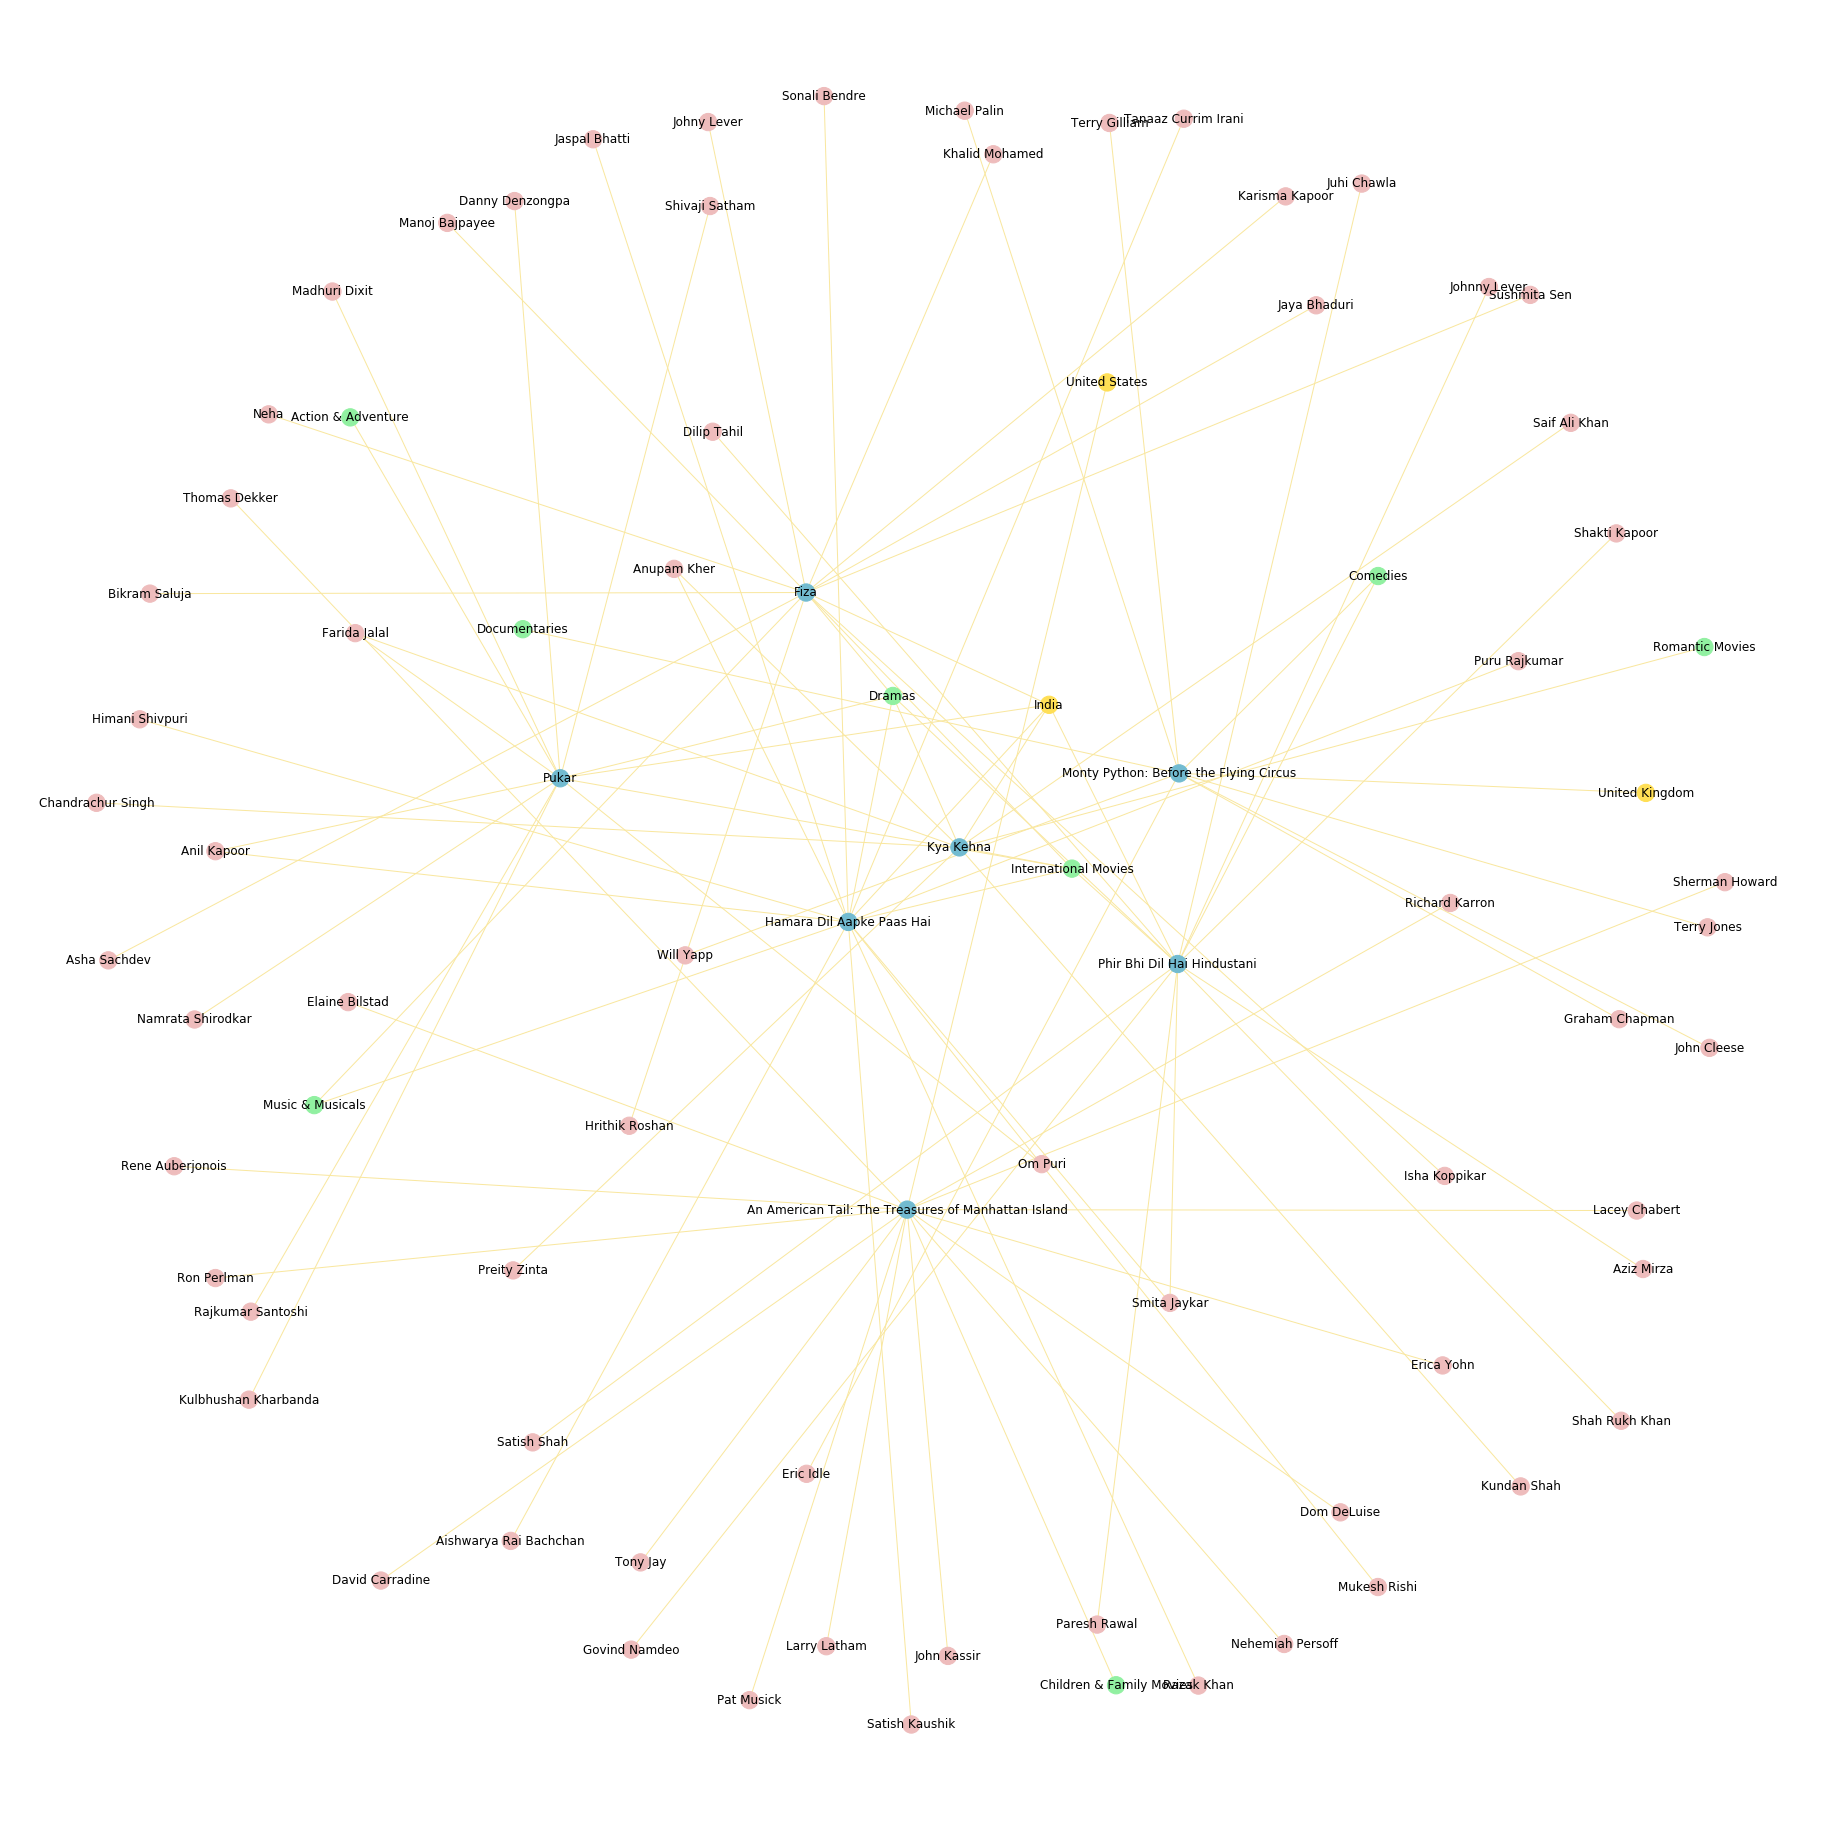

In [17]:
show_graph(G)

In [23]:
df_cat2 = df.loc[df['list_actors'].isin(['Julia Roberts','George Clooney'])]

In [24]:
print(df_cat2)

Empty DataFrame
Columns: [show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description, year, month, day, list_directors, list_categories, list_actors, list_countries]
Index: []


In [18]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    color_map = {"MOVIE":'#f09494', "PERSON":'#eebcbc', "CAT":'#72bbd0', "COU":'#91f0a1'} 

    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#F9E79F',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }

    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        colors = [color_map[G.nodes[e]['label']] for node in G]

    nx.draw(G, node_color=colors, pos=nx.spring_layout(G, k=0.80, iterations=50), **options)
    plt.show()

In [ ]:
#spark.stop()